<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
!rm news.*
!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
!unzip news.zip
%ls

rm: cannot remove 'news.*': No such file or directory
--2021-06-19 15:38:59--  https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11333903 (11M) [application/zip]
Saving to: ‘news.zip’

news.zip            100%[===================>]  10.81M  53.0MB/s    in 0.2s    

2021-06-19 15:39:00 (53.0 MB/s) - ‘news.zip’ saved [11333903/11333903]

Archive:  news.zip
  inflating: news.csv                
news.csv  news.zip  sample_data/


# Funções para processamento de Linguagem Natural

In [90]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ!,:.; ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf( V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    X_norm = StandardScaler(with_mean=False).fit_transform(X)
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X_norm)
    X_pca =  UT.fit_transform(X_norm)
      
    return [UT,X_pca]

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()


# Prepara dataset para clusterizacao

In [43]:
#abrir arquivo news.csv
dfDados = pd.read_csv('news.csv')
dfDados['TEXT_TRATADO'] = dfDados['TEXT_TRATADO'].astype('unicode')
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: removeCaracteresNaoDesejados(x['TEXT_TRATADO']),axis=1)
download_pt_stopWords()
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: removeStopWords(x['TEXT_TRATADO']),axis=1)
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: aplicaStemming(x['TEXT_TRATADO']),axis=1)
dfDados[['TEXT_TRATADO']].head(3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


,TEXT_TRATADO
0,sext bbb tv glob broth receb com beb faz aquec...
1,"program viv bbb tv globo, leifert convers empa..."
2,"continu dizendo, deu tir daquel cadeira. vai s..."


In [44]:
X = dfDados['TEXT_TRATADO'].values
min_fr=0.01; max_fr=0.7
vetores = retornaVetorizacao(X,min_fr,max_fr) 
V = vetores[0]
X_tfidf = retornaMatriztfIdf(V)


In [92]:
model = AgglomerativeClustering(distance_threshold=5, n_clusters=None)
model = model.fit(X_tfidf.toarray())
''' 10 gerou 5 grupos desbalanceados'''

SyntaxError: ignored

In [46]:
print('nro cluster:',model.n_clusters_)
distancia = model.distances_
print('distância minima:', distancia.min(), '\n distância máxima:', distancia.max())

nro cluster: 5
distância minima: 0.0 
 distância máxima: 14.32355324054458


In [70]:
y_pred = model.fit_predict(X_tfidf.toarray())
dfDados['y_pred'] = y_pred
dfDados.groupby(['y_pred'])['y_pred'].count()

y_pred
0     604
1    5047
2     613
3     386
4     502
Name: y_pred, dtype: int64

In [79]:
for y in np.sort(dfDados['y_pred'].unique()):
  print('Top 10 categorias de y_pred = ', y)
  print(dfDados[dfDados['y_pred']==y].groupby('CATEGORIA')['URL'].count().reset_index().sort_values(by='URL',ascending=False)[0:10])


Top 10 categorias de y_pred =  0
       CATEGORIA  URL
18         saude  222
10         local  153
4    coronavirus   85
13         mundo   46
15      politica   39
12    miscelanea   23
0         brasil   10
2        colunas    6
7       economia    3
1   celebridades    3
Top 10 categorias de y_pred =  1
     CATEGORIA  URL
33       local  817
39       mundo  676
36       midia  669
49    politica  536
37  miscelanea  430
25     esporte  374
17    economia  298
1       brasil  206
52       saude  162
9      colunas  149
Top 10 categorias de y_pred =  2
  CATEGORIA  URL
2   novelas  499
1     midia  113
0   atitude    1
Top 10 categorias de y_pred =  3
    CATEGORIA  URL
2       midia  371
3  miscelanea   10
4       mundo    2
0     esporte    1
1       local    1
5   realities    1
Top 10 categorias de y_pred =  4
               CATEGORIA  URL
14              politica  331
0                 brasil   54
12            miscelanea   28
2                colunas   28
9                justi

In [78]:
np.sort(dfDados['y_pred'].unique())

array([0, 1, 2, 3, 4])

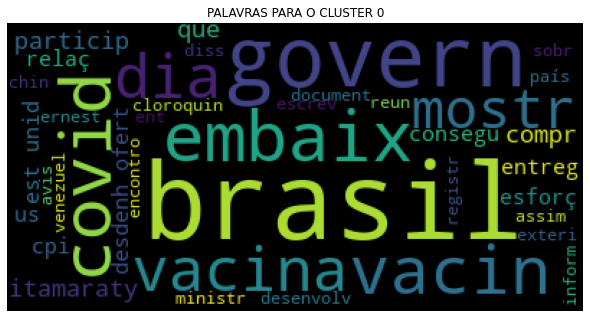

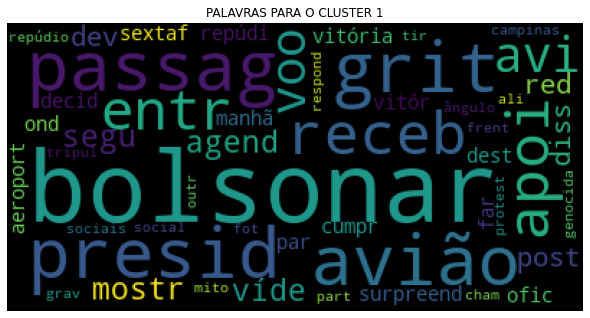

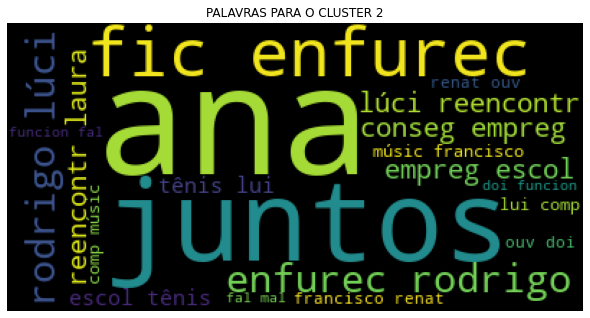

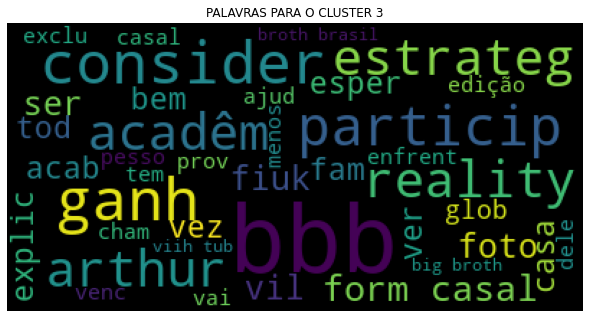

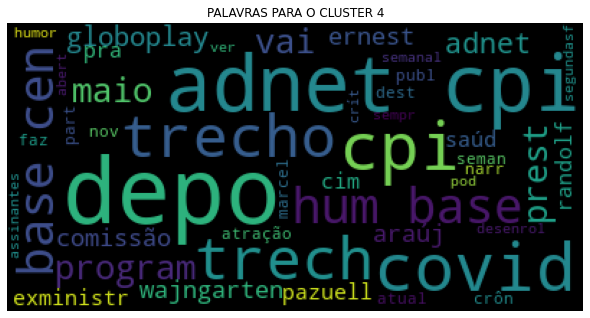

In [91]:
for y in np.sort(dfDados['y_pred'].unique()):
  dftmp = dfDados.loc[:,['TEXT_TRATADO']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['TEXT_TRATADO'].tolist(),50,str(y))

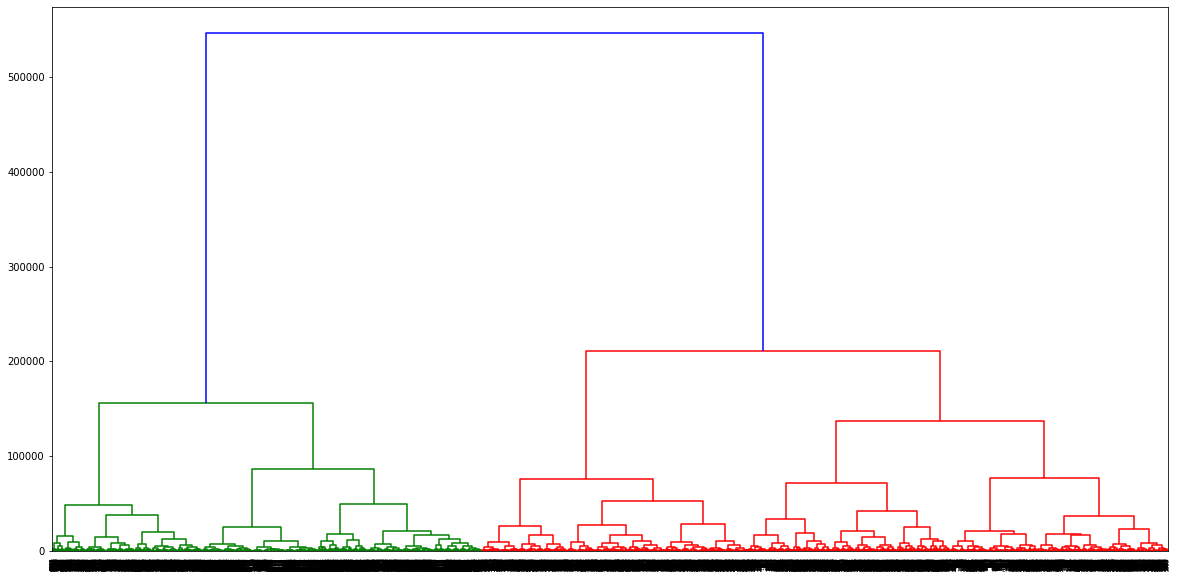

In [24]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
Z = hierarchy.linkage(model.children_, 'ward')
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)